# Medicare Clustering 

In [242]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns
import string
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
pd.options.display.max_rows = 4000

## Data Cleaning

### Loading Only Necessary Columns

In [243]:
# Renaming column names & Grabbing relevant columns
columns = ['npi', 'last_name', 'first_name', 'middle_initial', 'credentials',
           'gender', 'entity_code', 'street_1,', 'street_2', 'city', 'zip',
           'state', 'country', 'provider_type', 'medicare_participation_indicator',
           'place_of_service', 'hcpcs_code', 'hcpcs_desc', 'hcps_drug', 'services_count',
           'unique_patients_count', 'unique_patients_day_count', 'average_allowed_amount',
           'average_submitted_charge', 'average_medicare_payment',
           'average_medicare_payment_standardized']

relevant_columns = ['credentials', 'entity_code', 'city', 'state', 'country', 'provider_type',
                    'services_count', 'unique_patients_count', 'unique_patients_day_count',
                    'average_allowed_amount', 'average_submitted_charge', 'average_medicare_payment',
                    'average_medicare_payment_standardized']

relevant_numerical_columns = relevant_columns[6:]

df = pd.read_csv('CY2017.txt', sep="\t", header=0, skiprows=1, names=columns,
                 usecols=relevant_columns)

### Removing Outliers from Numerical Data

In [244]:
def drop_numerical_outliers(df, z_thresh=4):
    # Constrains will contain `True` or `False` depending on if it is a value below the threshold.
    constrains = df.select_dtypes(include=[np.number]) \
        .apply(lambda x: np.abs(stats.zscore(x)) < z_thresh, result_type='reduce') \
        .all(axis=1)
    df.drop(df.index[~constrains], inplace=True)
rows = df.shape[0]
drop_numerical_outliers(df)

In [245]:
# Percentage of samples removed by dropping outliers 
percent_removed = round((rows - df.shape[0])/rows * 100, 2)
print(f'{percent_removed}% of data points have been removed')

1.09% of data points have been removed


### Addressing 0-values for Log Transformations

In [246]:
# Function to replace 0-values with adjusted means for log graphing
def zero_remover(df, col):
    avg = df[col][df[col] > 0].mean()
    df.loc[df[col] == 0, col] = avg

# Apply function to these two columns 
zero_remover(df, 'average_medicare_payment')
zero_remover(df, 'average_medicare_payment_standardized')

## Exploratory Data Analysis 

### Histograms 

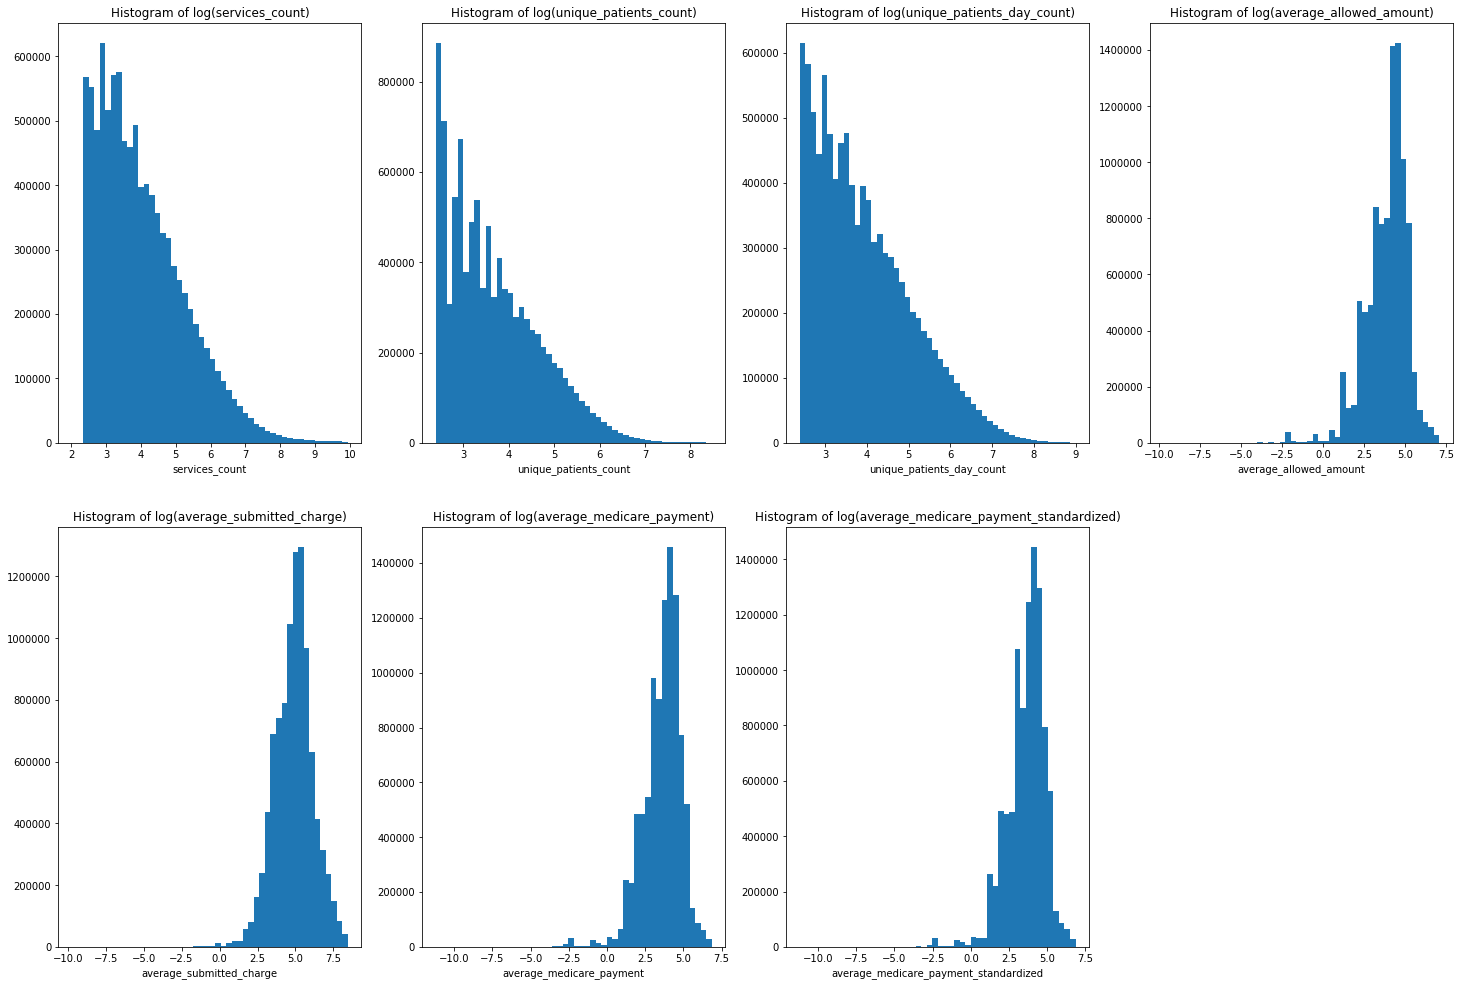

In [247]:
# Function to plot histograms for columns
def plotter(x, df):
    plt.hist(np.log(df[x]), bins=50)
    plt.xlabel(x)
    plt.title('Histogram of log(' + x + ')')
    

# Plot each column
j = 1 
plt.figure(figsize=(25,17))
for i in relevant_numerical_columns:
    plt.subplot(2, 4, j)
    plotter(i, df)
    j = j + 1


### Correllation Heatmap 

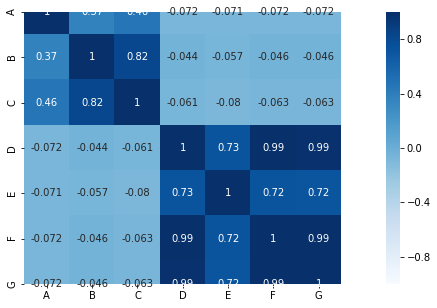

In [248]:
# Create a correlation heatmap for numerical columns
corr = df[relevant_numerical_columns].corr()
tick = list(string.ascii_uppercase[0:7])
plt.figure(figsize=(16, 5))
sns.heatmap(corr, xticklabels=tick, yticklabels=tick, square=True, vmin=-1, vmax=1, annot=corr, cmap ='Blues')

## Data Segmentation

In [249]:
## What groups of provider types are charging the most from medicare AND receiving the most?? Similarily, how much
## is medicare considering 'payment in full' (average allowed amount) for different provider types. 

### Data Trimming

In [ ]:
# Remove unncessary provider_types 
def provider_dropper(df, provider):
    df = df[df.provider_type != provider]
    return df
df = provider_dropper(df, 'All Other Suppliers')
df = provider_dropper(df, 'Unknown Supplier/Provider Specialty')

### Gathering *Training* and *Testing* Data

In [254]:
# Sampling data for training the model
def data_sampler(df, factor, it):
    keep = []
    for provider in it:
        keep.append(df[df.provider_type == provider].sample(frac = 1/factor, random_state = 0).index)
    keep = [item for sublist in keep for item in sublist]
    return keep
    
it = set(df['provider_type'])
train = data_sampler(df, 10, it)

Diagnostic Radiology                                1237535
Internal Medicine                                   1117353
Family Practice                                      968884
Nurse Practitioner                                   559711
Cardiology                                           442168
Physician Assistant                                  372623
Orthopedic Surgery                                   277286
Physical Therapist in Private Practice               274133
Ophthalmology                                        238083
Emergency Medicine                                   230847
Anesthesiology                                       229660
Dermatology                                          203559
Podiatry                                             188912
Gastroenterology                                     182268
Urology                                              180910
Hematology-Oncology                                  166405
Optometry                               

In [275]:
# Randomly selecting testing data
train = x 
df_less_train = df[~df.index.isin(train)] 
test = df_less_train.sample(n = len(train), random_state = 0).index

### Standardize Data of Interest

In [282]:
scaler = StandardScaler()
std_df = df[['average_allowed_amount', 'average_submitted_charge', 'average_medicare_payment_standardized']]
std_df = scaler.fit_transform(std_df)
#std_df = std_df[0:1000000]

### Determine Number of Clusters

In [144]:
maxClusters = 15
sse = []
for nClusters in range(2,maxClusters):
    kmeans = KMeans(n_clusters=nClusters, random_state=0).fit(std_df)
    sse.append(kmeans.inertia_)
    
kmeans = KMeans(n_clusters=5, random_state=0).fit(std_df)


[]


ValueError: x and y must have same first dimension, but have shapes (13,) and (0,)

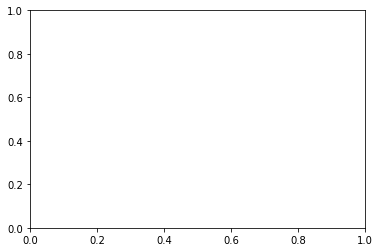

In [145]:
print(sse)
plt.plot(range(2,maxClusters),sse)